# Load raw files and importing

In [1]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

fraud_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/Fraud_Data.csv', parse_dates=["signup_time", "purchase_time"])
ip_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/IpAddress_to_Country.csv')
credit_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/creditcard.csv')

# Initial Summary
Checks conducted for duplicates, missing and null values. Overviews of shape and datatypes

In [2]:
def initial_summary(df, name):
    print(f"\n=== {name} ===")
    
    # Shape
    print("Shape:", df.shape)
    
    # Data types
    print("\nData types:")
    print(df.dtypes)

    # Check if any nulls exist (overall)
    has_nulls = df.isnull().values.any()
    print(f"\nAny null values present? {has_nulls}")
    
    # If there are nulls, list columns + counts
    if has_nulls:
        null_counts = df.isnull().sum()
        print("Nulls per column:")
        print(null_counts[null_counts > 0])
    
    # Missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # Duplicate rows
    print("\nTotal duplicate rows:", df.duplicated().sum())
    
    # Preview
    print("\nFirst 5 rows:")
    display(df.head())
    
# 3. Run summary on each raw dataset
initial_summary(fraud_raw,  "Fraud Data")
initial_summary(credit_raw, "Credit-Card Data")
initial_summary(ip_raw,     "IP→Country Mapping")


=== Fraud Data ===
Shape: (151112, 11)

Data types:
user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

Any null values present? False

Missing values per column:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Total duplicate rows: 0

First 5 rows:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0



=== Credit-Card Data ===
Shape: (284807, 31)

Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Any null values present? False

Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25      

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



=== IP→Country Mapping ===
Shape: (138846, 3)

Data types:
lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

Any null values present? False

Missing values per column:
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

Total duplicate rows: 0

First 5 rows:


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


# Check Class Imbalance in Raw Fraud and CC Data


Fraud Data — % of each class:
class
0    90.64
1     9.36
Name: proportion, dtype: float64


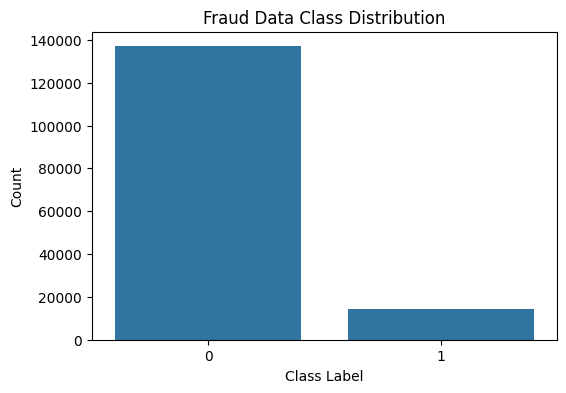


Credit-Card Data — % of each class:
Class
0    99.83
1     0.17
Name: proportion, dtype: float64


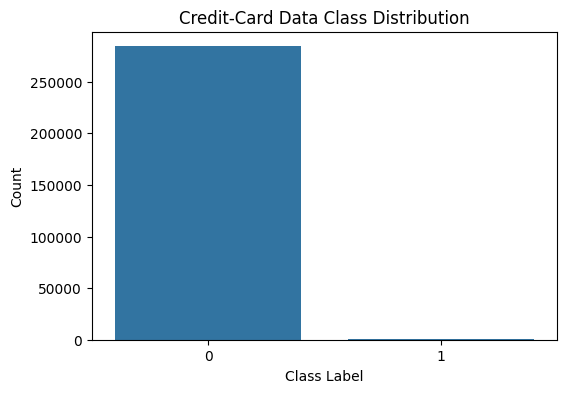

In [3]:
# Define list of (DataFrame, name, target column)
datasets = [
    (fraud_raw,  "Fraud Data","class"),
    (credit_raw, "Credit-Card Data","Class")
]

for df, title, target in datasets:
    # 1. Print percentage distribution
    pct = df[target].value_counts(normalize=True) * 100
    print(f"\n{title} — % of each class:")
    print(pct.round(2))
    
    # 2. Visualize with countplot
    plt.figure(figsize=(6,4))
    sns.countplot(x=target, data=df)
    plt.title(f"{title} Class Distribution")
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.show()


# IP Map Distribution & Coverage

Unique countries in map: 235

Top 10 countries by IP-range count:
country
United States         46868
Canada                 6989
Russian Federation     6739
Australia              6316
Germany                5999
United Kingdom         5401
Brazil                 4885
China                  3725
Poland                 3042
Japan                  3005
Name: count, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_6636\2525588252.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="magma")


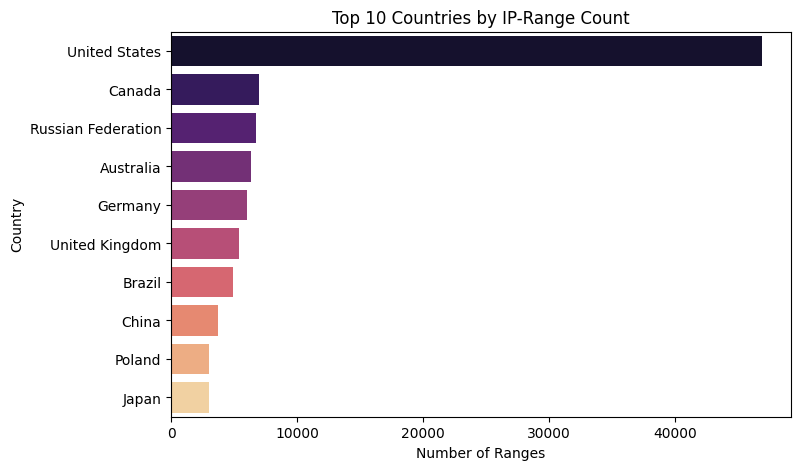

Bounds dtype: lower    int64
upper    int64
dtype: object
Any nulls in lower/upper? {'lower': False, 'upper': False}

Global IP-range covered:
Min lower: 16777216
Max upper: 3758096383


In [8]:
# 1. How many unique countries?
n_countries = ip_raw['country'].nunique()
print(f"Unique countries in map: {n_countries}")

# 2. Top 10 countries by number of IP ranges
top10 = ip_raw['country'].value_counts().head(10)
print("\nTop 10 countries by IP-range count:")
print(top10)

# 3. Bar plot of those top 10
plt.figure(figsize=(8,5))
sns.barplot(x=top10.values, y=top10.index, palette="magma")
plt.title("Top 10 Countries by IP-Range Count")
plt.xlabel("Number of Ranges")
plt.ylabel("Country")
plt.show()

ip_raw['lower'] = ip_raw['lower_bound_ip_address'].astype(int)
ip_raw['upper'] = ip_raw['upper_bound_ip_address'].astype(int)

print("Bounds dtype:", ip_raw[['lower','upper']].dtypes)
print("Any nulls in lower/upper?", ip_raw[['lower','upper']].isnull().any().to_dict())

# 5. IP coverage min/max
print("\nGlobal IP-range covered:")
print("Min lower:", ip_raw['lower'].min())
print("Max upper:", ip_raw['upper'].max())

